In [65]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings




# Model Selection

In [95]:

warnings.filterwarnings("ignore", category=UserWarning)

# Function to create the LSTM model with various hyperparameters
def create_lstm_model(input_shape, units=50, activation='relu', optimizer='adam', learning_rate=0.001, num_layers=2, dropout_rate=0.0):
    model = Sequential()
    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        if i == 0:
            model.add(LSTM(units=units, activation=activation, return_sequences=return_sequences, input_shape=input_shape))
        else:
            model.add(LSTM(units=units, activation=activation, return_sequences=return_sequences))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=1))
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    else:
        optimizer_instance = optimizer  # Extend with other optimizers if needed
    model.compile(optimizer=optimizer_instance, loss='mse')
    return model

# Function to perform model selection
def model_selection(X_train, y_train, input_shape):
    model = KerasRegressor(build_fn=create_lstm_model, input_shape=input_shape, verbose=0)
    param_grid = {
        'units': [50],
        'activation': ['relu'],#, 'tanh'],
        'optimizer': ['adam'],
        'learning_rate': [ 0.01],
        'num_layers': [2],
        'dropout_rate': [0.2],
        'batch_size': [32],
        'epochs': [25]
    }
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
    grid_result = grid.fit(X_train, y_train)
    return grid_result.best_estimator_

# Function to create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Updated function to get MAPE for varying sequence lengths
def get_mape(num_features, data, sequence_length):
    cols = data.columns
    data_main = data[cols[:num_features]].copy()
    data_main['Date'] = pd.to_datetime(data_main[['Year', 'Month']].assign(DAY=1))
    data = data_main[['Date', 'mean']]
    data.set_index('Date', inplace=True)
    data = data[data['mean'] >= -50]
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    X, y = create_sequences(data_scaled, sequence_length)
    train_size = int(len(X) * 0.80)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    best_model = model_selection(X_train, y_train, (sequence_length, 1))

    best_model.fit(X_train, y_train, verbose=0)

    y_pred = best_model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
    return mape



/var/folders/nx/cbq9gbgj2kg2bm1nwblk2fzm0000gn/T/ipykernel_7616/3184810672.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, input_shape=input_shape, verbose=0)
/var/folders/nx/cbq9gbgj2kg2bm1nwblk2fzm0000gn/T/ipykernel_7616/3184810672.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, input_shape=input_shape, verbose=0)
/var/folders/nx/cbq9gbgj2kg2bm1nwblk2fzm0000gn/T/ipykernel_7616/3184810672.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


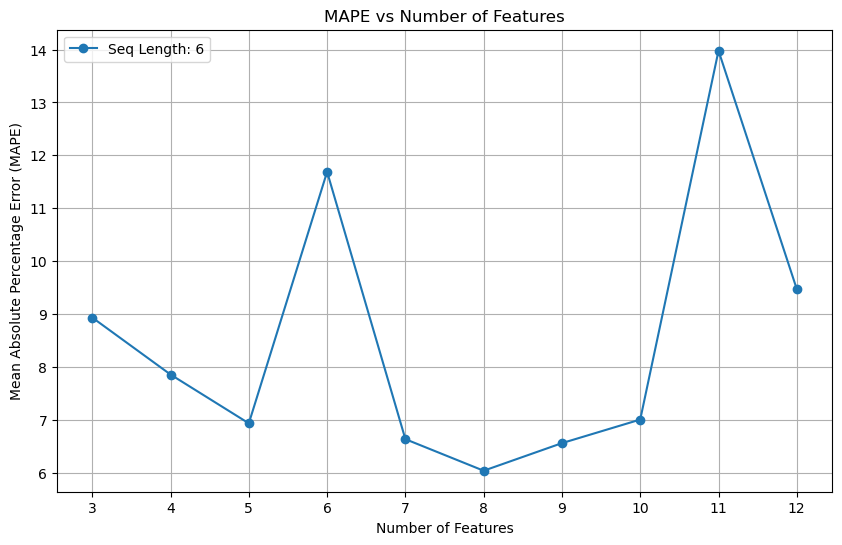

In [9]:
warnings.filterwarnings("ignore", category=UserWarning)
# Load the data
data = pd.read_csv('main_df.csv')
range_f = range(3,13) # we can make till 13
# Iterate over num_features and different sequence lengths, and plot MAPE
sequence_lengths = [6]  # Example sequence lengths
for sequence_length in sequence_lengths:
    mape_values = []
    for num_features in range_f :
        mape = get_mape(num_features, data, sequence_length)
        mape_values.append(mape)

    plt.figure(figsize=(10, 6))
    plt.plot(range_f, mape_values, marker='o', label=f'Seq Length: {sequence_length}')
    plt.title('MAPE vs Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean Absolute Percentage Error (MAPE)')
    plt.xticks(range_f)
    plt.legend()
    plt.grid(True)

plt.show()

# Model Evaluation

In [96]:
best_hyperparameters = {
    'units': 50,                # Number of units in each LSTM layer
    'activation': 'relu',       # Activation function for the LSTM layers
    'optimizer': 'adam',        # Optimizer used for training
    'learning_rate': 0.01,      # Learning rate for the optimizer
    'num_layers': 4,            # Number of LSTM layers in the model
    'dropout_rate': 0.0         # Dropout rate for regularization
}

# Assuming `best_num_features` is the number of features with the lowest MAPE
best_num_features =  4   # the number of features with the lowest MAPE
best_sequence_length = 6 # the sequence length that gave the lowest MAPE

data = pd.read_csv('main_df.csv')

# Re-prepare the data with the best_num_features
cols = data.columns
data_main = data[cols[:best_num_features]].copy()
data_main['Date'] = pd.to_datetime(data_main[['Year', 'Month']].assign(DAY=1))
data = data_main[['Date', 'mean']]
data.set_index('Date', inplace=True)
data = data[data['mean'] >= -50]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare sequences with the best sequence length
X, y = create_sequences(data_scaled, best_sequence_length)




In [97]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.90)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Reshape the data for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Retrain the model with the best hyperparameters
input_shape = (best_sequence_length, 1)
model = create_lstm_model(input_shape, **best_hyperparameters)

# Train the model
model.fit(X, y, epochs=100, batch_size=32, verbose=0)


# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values to the original scale
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 [==============================] - 0s 2ms/step


Mean Absolute Percentage Error (MAPE) in %: 5.378815468063614


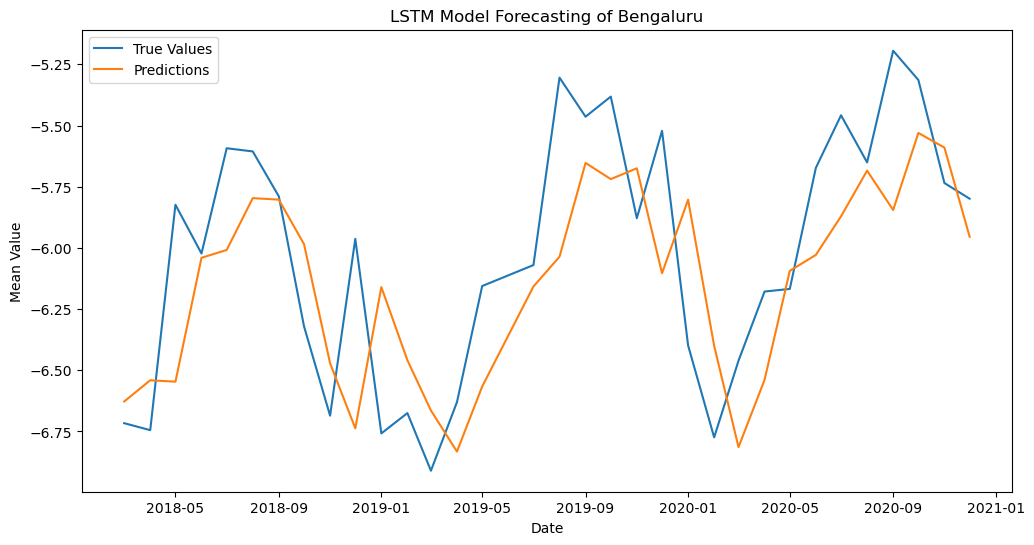

In [98]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("Mean Absolute Percentage Error (MAPE) in %:", mape)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size + best_sequence_length:], y_test_inv, label='True Values')
plt.plot(data.index[train_size + best_sequence_length:], y_pred_inv, label='Predictions')
plt.title('LSTM Model Forecasting of Bengaluru')
plt.xlabel('Date')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

## Forecast till 2030

In [90]:
best_hyperparameters = {
    'units': 50,                # Number of units in each LSTM layer
    'activation': 'relu',       # Activation function for the LSTM layers
    'optimizer': 'adam',        # Optimizer used for training
    'learning_rate': 0.01,      # Learning rate for the optimizer
    'num_layers': 4,            # Number of LSTM layers in the model
    'dropout_rate': 0.0         # Dropout rate for regularization
}

# Assuming `best_num_features` is the number of features with the lowest MAPE
best_num_features =  8 # the number of features with the lowest MAPE
best_sequence_length = 70 # the sequence length that gave the lowest MAPE

data = pd.read_csv('main_df.csv')

# Re-prepare the data with the best_num_features
cols = data.columns
data_main = data[cols[:best_num_features]].copy()
data_main['Date'] = pd.to_datetime(data_main[['Year', 'Month']].assign(DAY=1))
data = data_main[['Date', 'mean']]
data.set_index('Date', inplace=True)
data = data[data['mean'] >= -50]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare sequences with the best sequence length
X, y = create_sequences(data_scaled, best_sequence_length)




In [91]:
import random
import tensorflow as tf
# Set a random seed for reproducibility
seed_value = 42

np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

input_shape = (best_sequence_length, 1)
model1 = create_lstm_model(input_shape, **best_hyperparameters)
model1.fit(X, y, epochs=100, batch_size=32, verbose=0)




1/1 [==============================] - 0s 11ms/step


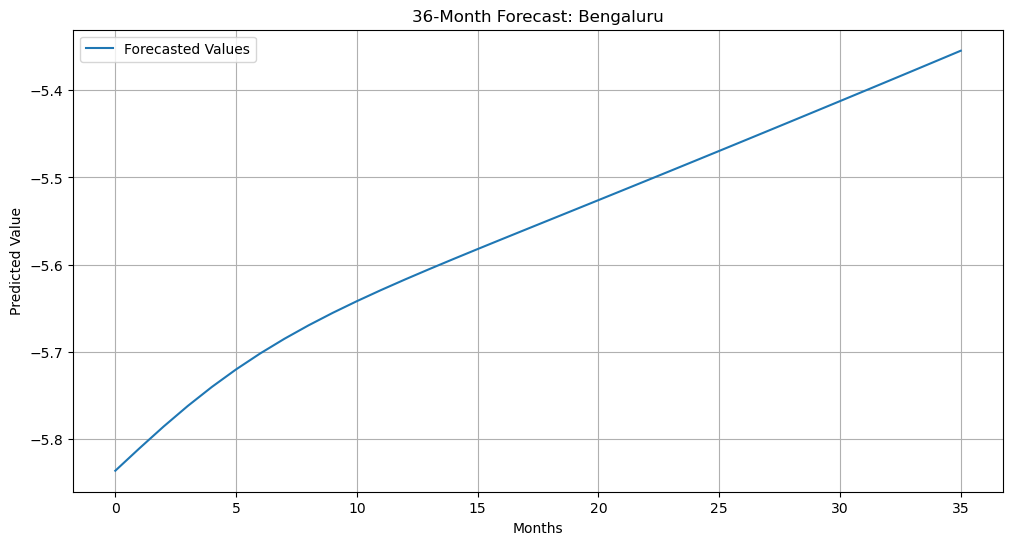

In [93]:
# Function to make predictions for future months
def forecast(model1, initial_sequence, months_to_predict, sequence_length):
    current_sequence = initial_sequence.copy()
    predictions = []
    for _ in range(months_to_predict):
        # Reshape current_sequence to fit the model1's expected input shape
        current_sequence_reshaped = current_sequence[-sequence_length:].reshape(1, sequence_length, -1)
        
        # Predict the next step and append to predictions
        next_prediction = model1.predict(current_sequence_reshaped)
        predictions.append(next_prediction.ravel()[0])
        
        # Update the current_sequence to include the new prediction
        current_sequence = np.append(current_sequence, next_prediction.ravel()[0])

    return np.array(predictions)

# Use the last sequence_length values from data_scaled as initial sequence
initial_sequence = data_scaled


# Forecast for the next 36 months
months_to_predict = 36
future_predictions = forecast(model1, initial_sequence, months_to_predict, best_sequence_length)

# Inverse transform the predictions to the original scale
future_predictions_inv = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# future_predictions_inv contains the forecast for the next 60 months

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(range(months_to_predict), future_predictions_inv, label='Forecasted Values')
plt.title('36-Month Forecast: Bengaluru')
plt.xlabel('Months')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.show()